In [250]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

Prepare dataset for experiments

In [274]:
nb_samples = 1000
nb_unlabeled = 900
random_state = 42
n_class = 3

In [297]:
X, y = make_blobs(n_samples=nb_samples, n_features=2, centers=n_class, cluster_std=4, random_state=random_state)
y_true = y.copy()

In [298]:
y[:15]

array([2, 2, 1, 0, 0, 2, 1, 1, 1, 1, 0, 2, 0, 1, 1])

Set unknown label for random instances

In [299]:
np.random.seed(random_state)
unlabeled_idx = np.random.choice(np.arange(0, nb_samples, 1), replace=False, size=nb_unlabeled,)
y[unlabeled_idx] = -1

In [300]:
y[:15]

array([-1,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1])

Plot dataset

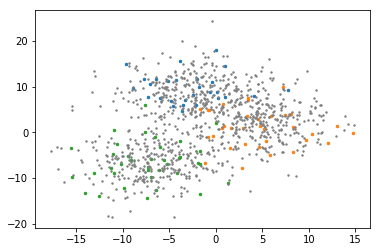

In [301]:
def plot_dataset():
    for i in range(n_class):
        plt.scatter(X[y==i, 0], X[y==i, 1], s=6)
    
    plt.scatter(X[y==-1, 0], X[y==-1, 1], c='grey', s=2)
    
plot_dataset()

Generate random distributions

In [302]:
m, c = [], []

for i in range(n_class):
    m.append(np.random.uniform(-7.5, 10.0, size=2))
    c1 = np.random.uniform(5.0, 15.0, size=(2, 2))
    c1 = np.dot(c1, c1.T)
    c.append(c1)
q1 = 0.5

In [303]:
m[0]

array([ 9.82430407, -1.85880771])

In [304]:
c[0]

array([[228.52535817, 249.86394009],
       [249.86394009, 298.41229415]])

Plot distribution

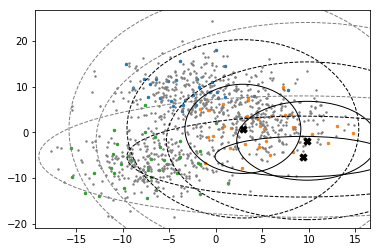

In [305]:
def plot_distribution(m, c, ax):
    ax.scatter(m[0], m[1], s=50, c='black', marker='X')
    c0 = np.sqrt(c[0])
    c1 = np.sqrt(c[1])
    ell1 = Ellipse(m, c0, c1, fill=False, edgecolor='black', lw=1)
    ell2 = Ellipse(m, 2*c0, 2*c1, fill=False, edgecolor='black', ls='dashed')
    ell3 = Ellipse(m, 3*c0, 3*c1, fill=False, edgecolor='grey', ls='dashed')
    ax.add_artist(ell1)
    ax.add_artist(ell2)
    ax.add_artist(ell3)

fig, ax = plt.subplots()    
plot_dataset()

for i in range(n_class):
    plot_distribution(m[i], np.diag(c[i]), ax)

Create Gaussian Mixture Model

In [306]:
gm = GaussianMixture(n_components=n_class, covariance_type='diag', random_state=random_state)
gm.fit(X[y != -1], y[y != -1])

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

Covariance matrix

In [307]:
gm.covariances_

array([[20.1247794 , 14.86131441],
       [18.87439068, 16.65909882],
       [11.7637923 , 13.47437739]])

Means for predicted distribution

In [308]:
gm.means_

array([[-7.13031243, -7.1655733 ],
       [ 4.73533771,  1.46730207],
       [-3.20256606,  9.02728314]])

Plot predicted distribution

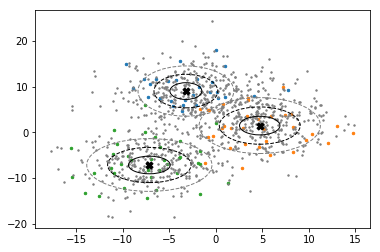

In [309]:
fig, ax = plt.subplots()    
plot_dataset()

for i in range(n_class):
    plot_distribution(gm.means_[i], gm.covariances_[i], ax)

Plot predicted clusters

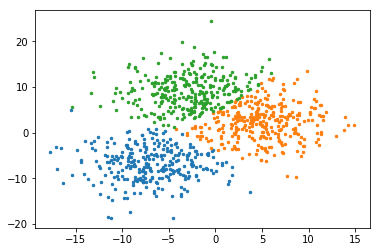

In [310]:
def plot_prediction(X, y_pred):
    for i in range(n_class):
        idx = y_pred==i
        plt.scatter(X[idx, 0], X[idx, 1], s=6)
        
plot_prediction(X[y==-1], gm.predict(X[y==-1]))

Try classifier with only labeled dataset

In [311]:
kmean = KNeighborsClassifier()
kmean.fit(X[y!=-1], y[y!=-1])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [312]:
print(classification_report(y_true[y == -1], kmean.predict(X[y == -1])))

              precision    recall  f1-score   support

           0       0.92      0.79      0.85       305
           1       0.79      0.92      0.85       299
           2       0.97      0.95      0.96       296

    accuracy                           0.89       900
   macro avg       0.89      0.89      0.89       900
weighted avg       0.89      0.89      0.89       900



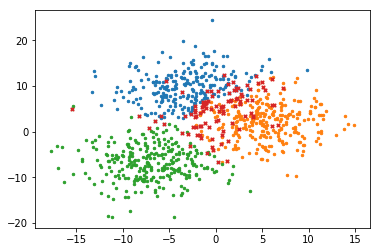

In [318]:
def plot_errors(X, y_true, y_pred):
    plt.scatter(X[y_pred!=y_true, 0], X[y_pred!=y_true, 1], s=12, marker='x')

y_pred = kmean.predict(X[y==-1])
plot_prediction(X[y==-1], y_pred)
plot_errors(X[y==-1], y_true[y==-1], y_pred)